In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

# Criar uma base de dados com proporção 1:100
# Criar uma base de dados com proporção 1:100
X, y = make_classification(
    n_samples=10000, 
    n_features=20, 
    n_informative=10, 
    n_redundant=10, 
    n_clusters_per_class=3, 
    weights=[0.99], 
    flip_y=0,
    random_state=42
)

# Lista de estratégias de amostragem
max_strategy = sum(y == 1) / sum(y == 0)
sampling_strategies = np.linspace(1, max_strategy, 20)

# Lista para armazenar os f1-scores
f1_scores = []

# Validação cruzada estratificada com 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for strategy in sampling_strategies:
    print(strategy)
    f1_scores_fold = []  # Lista para armazenar o f1-score de cada fold
    
    for train_index, test_index in kf.split(X, y):
        # Dividir os dados de treino e teste para o fold atual
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if strategy != sampling_strategies[-1]:
            # Aplicar o método de random undersampling
            rus = RandomUnderSampler(sampling_strategy=strategy, random_state=42)
            X_res, y_res = rus.fit_resample(X_train, y_train)
            
        else:
            X_res, y_res = X_train, y_train
        
        # Treinar o modelo
        model = LogisticRegression()
        model.fit(X_res, y_res)
        
        # Fazer previsões no conjunto de teste
        y_pred = model.predict(X_test)
        
        # Avaliar o modelo com f1-score para o fold atual
        f1 = f1_score(y_test, y_pred)
        f1_scores_fold.append(f1)
        # Otimizar o ponto de corte de y_pred de acordo com a curva ROC

        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        # Aplicar o ponto de corte otimizado
        y_pred = (model.predict_proba(X_test)[:, 1] >= optimal_threshold).astype(int)
    
    # Calcular a média do f1-score para a estratégia atual
    f1_scores.append(np.mean(f1_scores_fold))

# f1_scores agora contém a média dos f1-scores para cada estratégia de amostragem

1.0
0.9478946836842637
0.8957893673685273
0.843684051052791
0.7915787347370548
0.7394734184213184
0.6873681021055821
0.6352627857898459
0.5831574694741095
0.5310521531583732
0.47894683684263684
0.4268415205269005
0.37473620421116416
0.3226308878954278
0.2705255715796916
0.21842025526395525
0.16631493894821892
0.11420962263248258
0.06210430631674624
0.009998990001009999


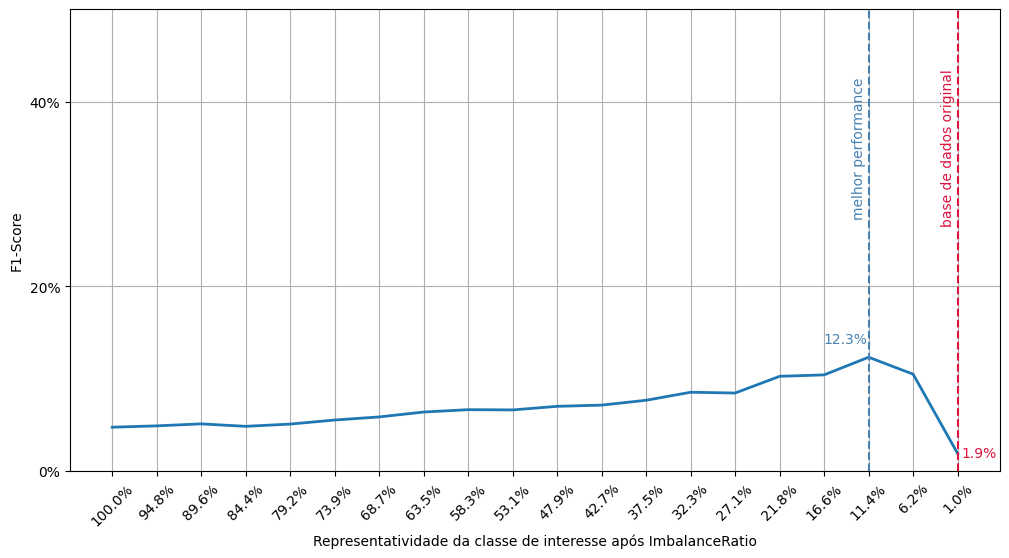

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(
    sampling_strategies,
    f1_scores,
    linewidth=2,
    
    label='F1-Score'
)

plt.gca().invert_xaxis()

# Eixo Y
plt.yticks(
    np.arange(0, 1.1, 0.2),
    [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.2)]
)
plt.ylim(0, .5)

# Adicionar linha vertical
plt.axvline(x=sampling_strategies[-1], color='crimson', linestyle='--')
plt.text(sampling_strategies[-1]+0.02, 0.35, 'base de dados original', color='crimson', rotation=90, verticalalignment='center')
plt.text(sampling_strategies[-1]-0.005, f1_scores[-1], f'{f1_scores[-1]*100:.1f}%', color='crimson', verticalalignment='center')

# Adicionar linha vertical para o melhor ponto
plt.axvline(x=sampling_strategies[-3], color='steelblue', linestyle='--')
plt.text(sampling_strategies[-3]+0.02, 0.35, 'melhor performance', color='steelblue', rotation=90, verticalalignment='center')
plt.text(sampling_strategies[-3]+0.0525,  f1_scores[-3]+0.02, f'{f1_scores[-3]*100:.1f}%', color='steelblue', verticalalignment='center')

# Eixo X
plt.xticks(
    sampling_strategies,
    [f'{i*100:.1f}%' for i in sampling_strategies],
    rotation = 45
)

plt.xlabel("Representatividade da classe de interesse após ImbalanceRatio")
plt.ylabel("F1-Score")

plt.grid()
plt.plot()

plt.show()
